# Load Data

In [2]:
import pandas

chiller1 = pandas.read_csv('chiller1.csv', index_col=0, parse_dates=[0])
chiller1.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 229677 entries, 2021-04-30 08:50:12 to 2022-03-02 17:53:28
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   Flow       229677 non-null  float64
 1   EnterTemp  229677 non-null  float64
 2   LeaveTemp  229677 non-null  float64
 3   kWE        229677 non-null  float64
dtypes: float64(4)
memory usage: 8.8 MB


# Compute Refrigeration and COP Columns

In [3]:
def computeRefrigeration(row) :
    if row.EnterTemp > row.LeaveTemp :
        return (row.EnterTemp - row.LeaveTemp) * row.Flow * 4.19
    else :
        return 0

chiller1['kWR'] = chiller1.apply(computeRefrigeration, axis=1)

In [4]:
def computeCoefficientOfPerformance(row) :
    if row.kWE > 0 :
        return row.kWR / row.kWE
    else :
        return None

chiller1['COP'] = chiller1.apply(computeCoefficientOfPerformance, axis=1)

# Only focus on when the Chiller is running

In [5]:
chiller1['month'] = chiller1.index.month # needed later for box plot

In [6]:
working = chiller1[chiller1.kWE > 0]

# Basic Data Summary

In [7]:
chiller1.describe()

,Flow,EnterTemp,LeaveTemp,kWE,kWR,COP,month
count,229677.000000,229677.000000,229677.000000,229677.000000,229677.000000,1.841120e+05,229677.000000
mean,21.037793,11.549254,8.333101,40.990809,360.995484,9.673558e+00,7.202106
std,10.311329,2.204473,3.417487,42.820836,296.457111,3.030989e+00,3.687593
min,0.000000,7.000000,4.600000,0.000000,0.000000,7.192304e-39,1.000000
25%,20.962748,9.900000,6.000000,8.640777,128.000000,7.607281e+00,5.000000
50%,21.908083,11.100000,6.800000,30.847458,316.281921,8.700000e+00,8.000000
75%,25.510635,12.800000,9.400000,59.750000,527.744855,1.136639e+01,10.000000
max,46.457832,24.000000,24.200001,3280.000000,1673.117813,3.896851e+01,12.000000


# Basic Plots of Raw Data

In [8]:
def basicPlot(column) :
    chiller1[column].plot(figsize=(15,5), title=column + ' by Date', xlabel='Date', ylabel=column)

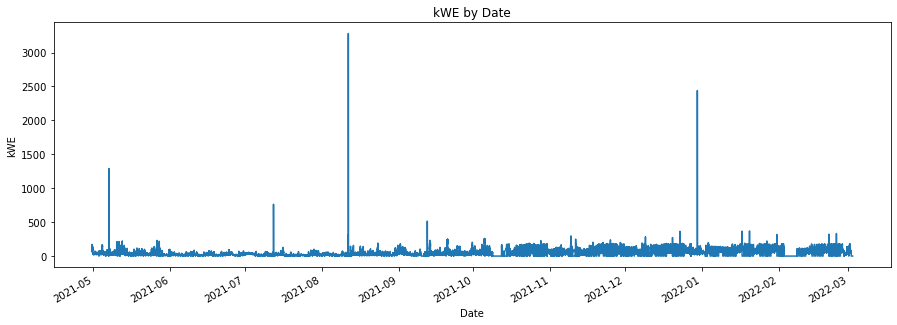

In [9]:
basicPlot('kWE')

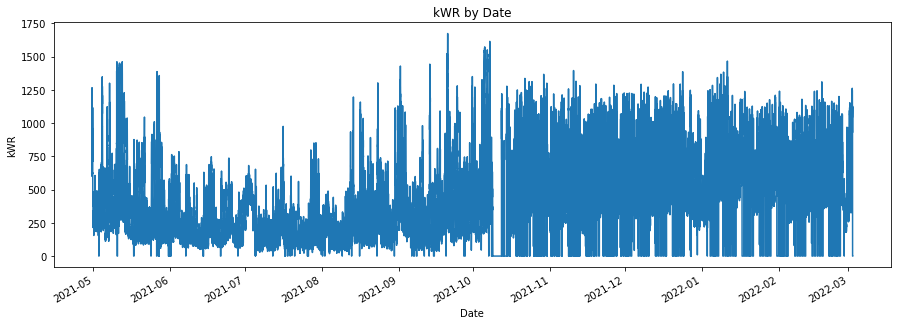

In [10]:
basicPlot('kWR')

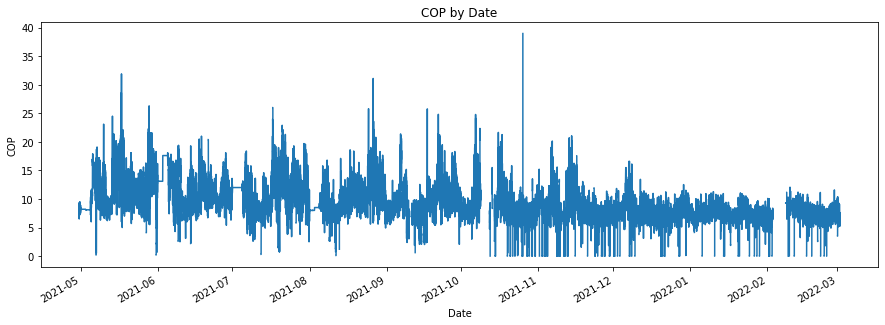

In [11]:
basicPlot('COP')

# Patterns by Month of Year

In [12]:
month_labels = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']

def PlotByMonth(column) :
  group = working.groupby(working.index.month)[column]
  ax = group.mean().plot.line(yerr = group.std(), figsize=(15,5), ecolor='lightgreen', elinewidth=5, capsize=5, color='orange', title ='Average ' + column + ' by Month', xlabel='Month', ylabel=column)
  ax.set_xticks(ticks = range(1,13), labels=month_labels)

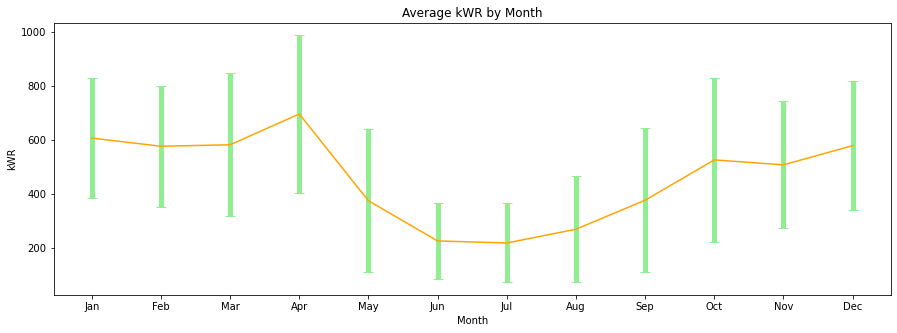

In [13]:
PlotByMonth('kWR')

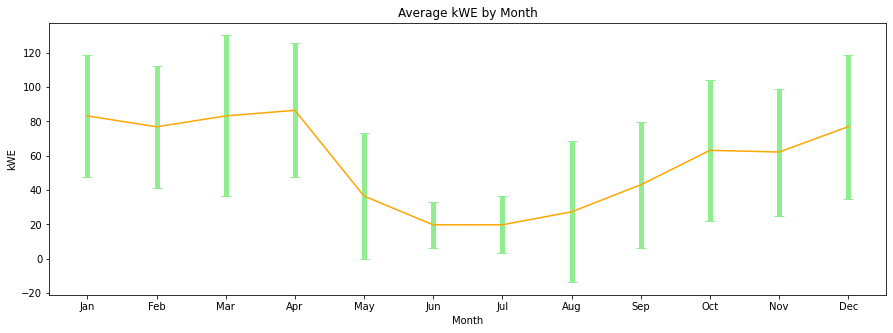

In [14]:
PlotByMonth('kWE')

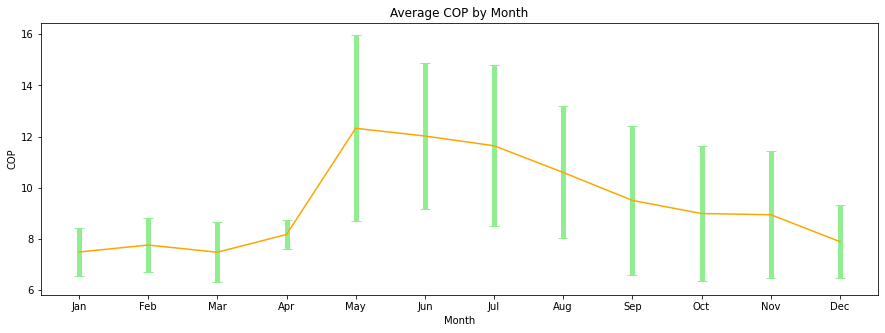

In [15]:
PlotByMonth('COP')

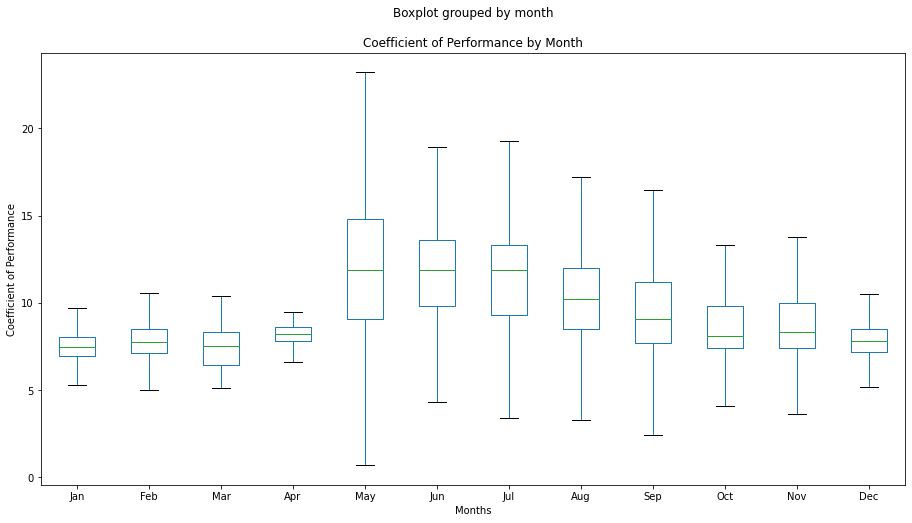

In [16]:
# Demonstrating box plot 
p = working.boxplot(column='COP', by='month', figsize=(15,8), grid=False, showfliers=False)
p.set_title('Coefficient of Performance by Month')
p.set_ylabel('Coefficient of Performance')
p.set_xticks(ticks = range(1,13), labels=month_labels)
x = p.set_xlabel('Months')  

# Patterns by Day of Week

In [17]:
day_labels = ['Mon','Tue', 'Wed','Thu','Fri','Sat','Sun']

def PlotByDayOfWeek(column) :
    group = working.groupby(working.index.dayofweek)[column]
    mean = group.mean()
    plot = mean.plot.line(figsize=(15,8))
    plot.set_xticks(range(0,len(day_labels)), day_labels)
    plot.set_title('Average ' + column + ' by Day of Week')
    plot.set_xlabel('Day of Week')
    plot.set_ylabel(column)

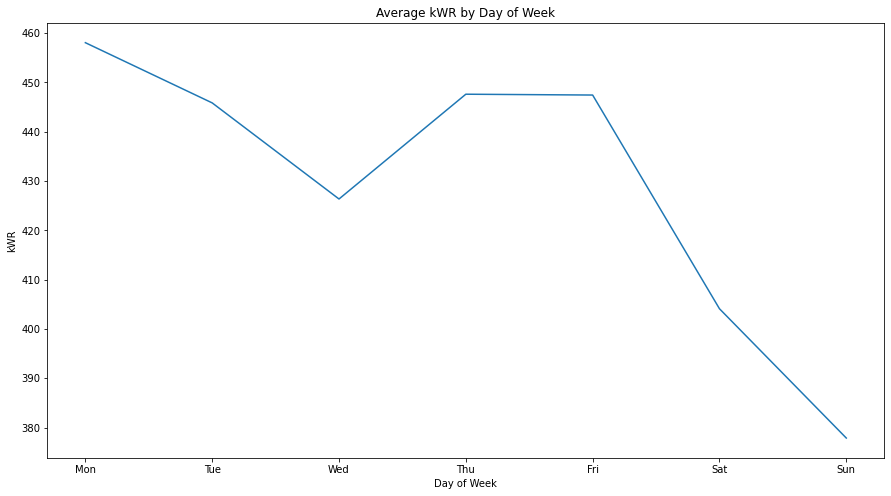

In [18]:
PlotByDayOfWeek('kWR')

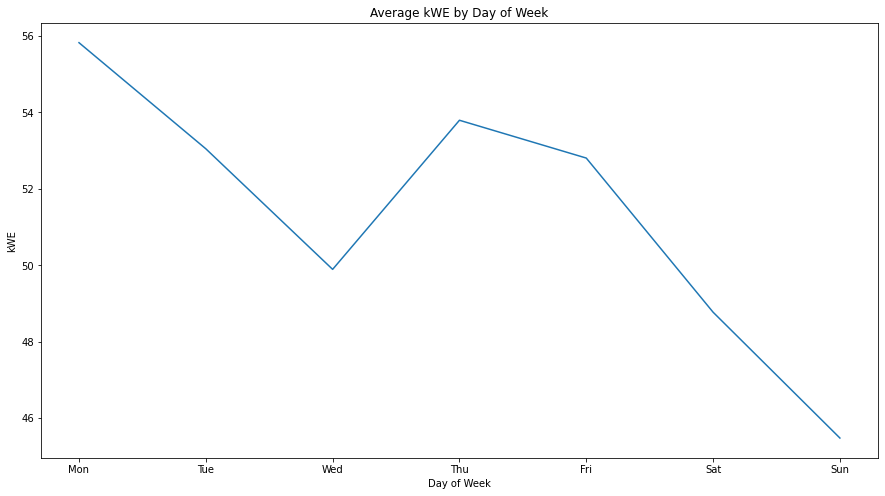

In [19]:
PlotByDayOfWeek('kWE')

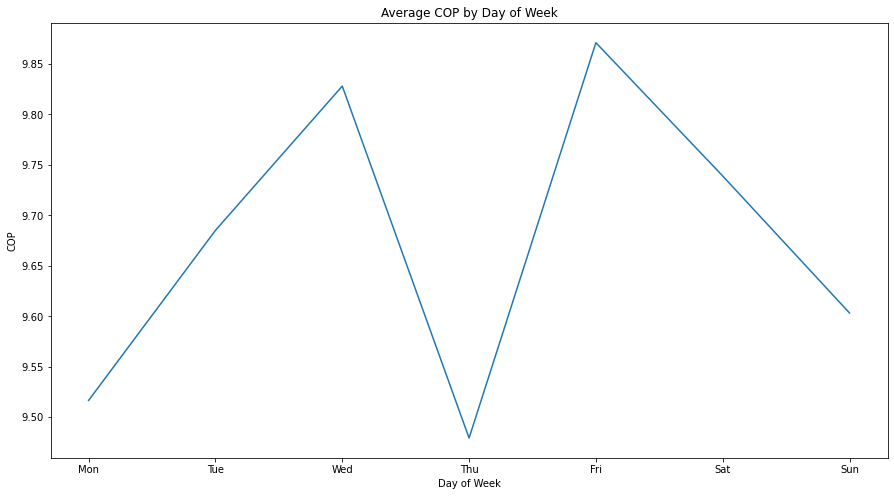

In [20]:
PlotByDayOfWeek('COP')

# Patterns by Hour of Day

In [21]:
def PlotByHourOfDay(column) :
    hours = working.groupby(working.index.hour)[column]
    plot = hours.mean().plot(yerr = hours.std(), figsize=(15,5), ecolor='lightgreen', elinewidth=5, capsize=5,color='orange')
    plot.set_title('Average ' + column + ' by Hour of Day')
    plot.set_xlabel('Hour')
    plot.set_ylabel(column)
    plot.set_xticks(range(0,24))    

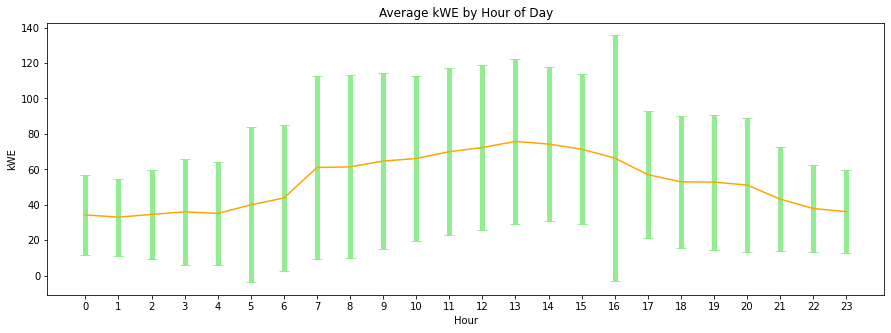

In [22]:
PlotByHourOfDay('kWE')

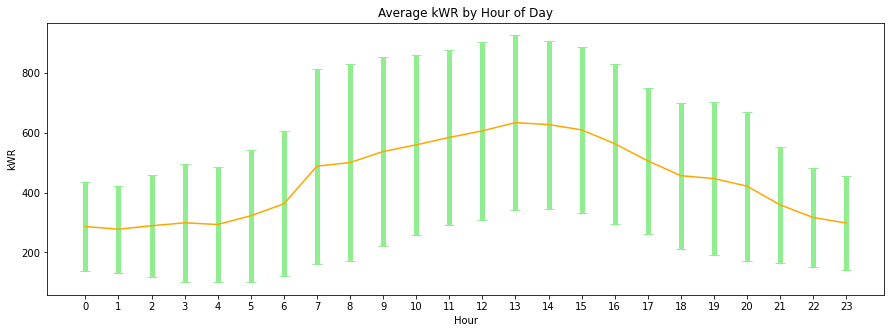

In [23]:
PlotByHourOfDay('kWR')

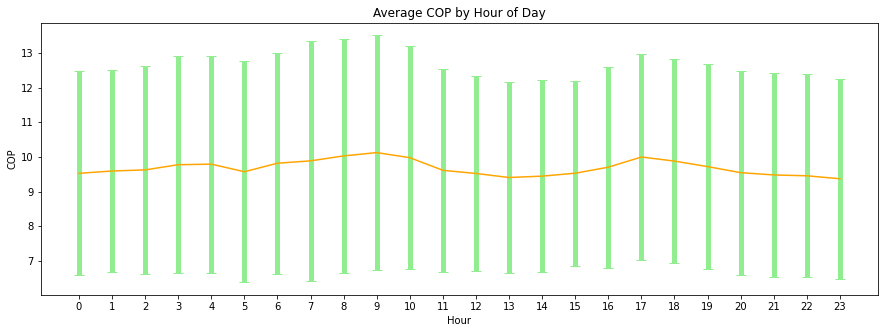

In [24]:
PlotByHourOfDay('COP')

# On my birthday 25 July

In [25]:
birthday = working[(working.index.month == 7) & (working.index.day == 25)]

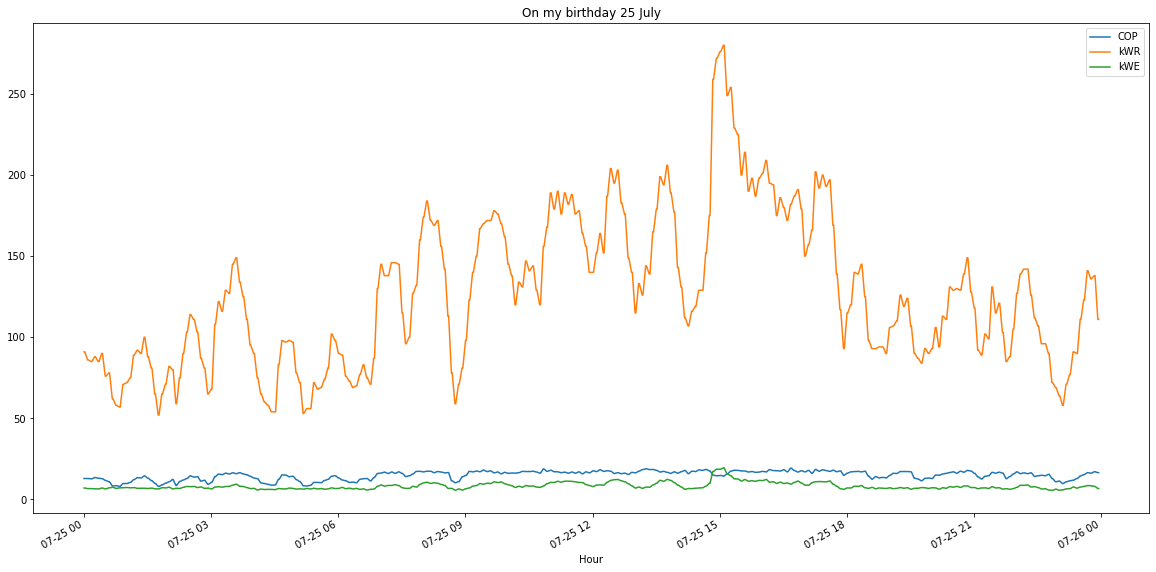

In [26]:
ax = birthday[['COP', 'kWR', 'kWE']].plot(figsize=(20,10))
ax.set_xlabel('Hour')
ax.set_title('On my birthday 25 July');

In [27]:
# demonstrating fill between
def PlotOnDay(column, dayData) :
    group = dayData.groupby(dayData.index.hour)[column]
    mean = group.mean()
    plot = mean.plot(y=column, figsize=(15,5))
    plot.fill_between(mean.index, group.min(), group.max(), alpha=0.1)
    plot.set_title('Average ' + column + ' by Hour')
    plot.set_xlabel('Hour')
    plot.set_ylabel(column)
    plot.set_xticks(range(0,24))

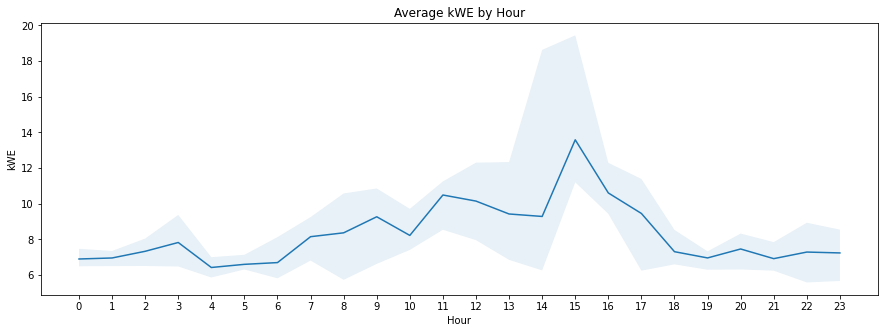

In [28]:
PlotOnDay('kWE', birthday)

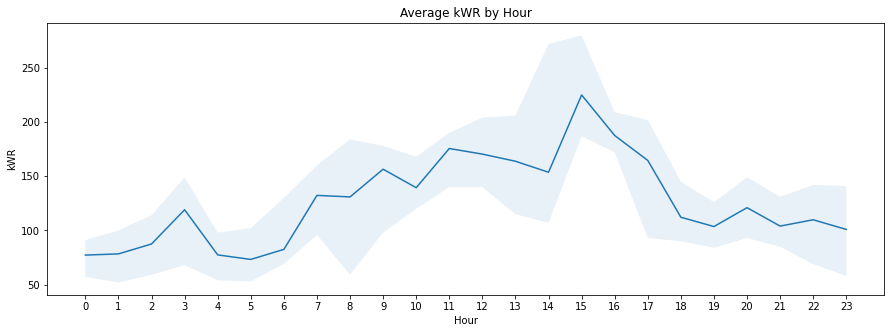

In [29]:
PlotOnDay('kWR', birthday)

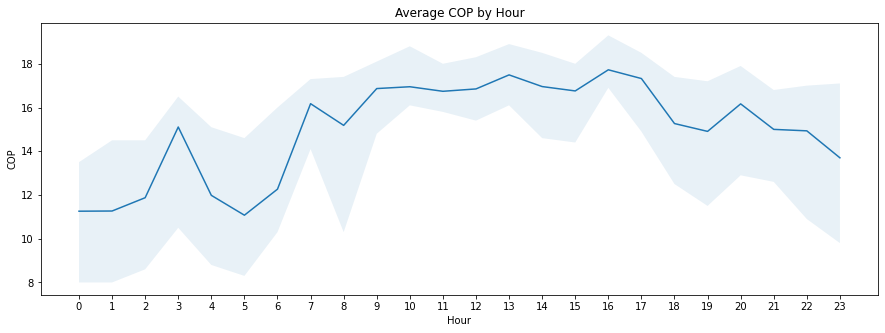

In [30]:
PlotOnDay('COP', birthday)

# Coefficient of  Performance  vs Refrigeration Load

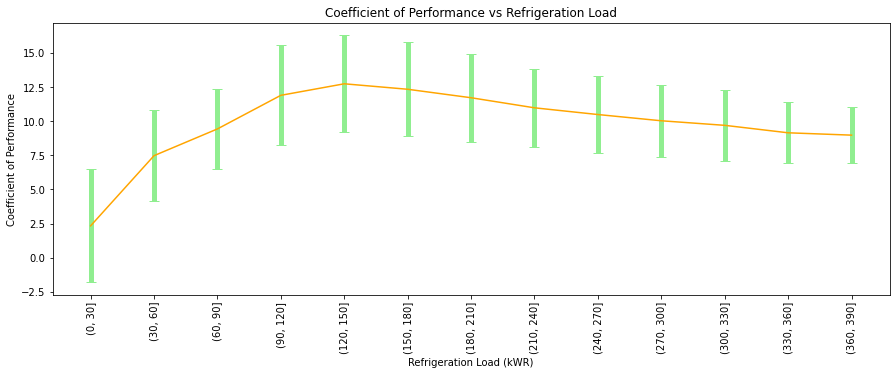

In [31]:
def PlotCOPvsLoad(lower = 0, upper = working.kWR.max(), step = 50) :
    bins = range(int(lower), int(upper), int(step))
    group = working.groupby(pandas.cut(working.kWR, bins)).COP
    data = group.mean()
    plot = data.plot.line(figsize=(15,5), yerr=group.std(), ecolor='lightgreen', elinewidth=5, capsize=5,color='orange')
    plot.set_xticks(ticks=range(len(data.index)), labels=data.index, rotation=90)
    plot.set_title('Coefficient of Performance vs Refrigeration Load')
    plot.set_ylabel('Coefficient of Performance')
    plot.set_xlabel('Refrigeration Load (kWR)')
    
PlotCOPvsLoad(0, 400, 30)  

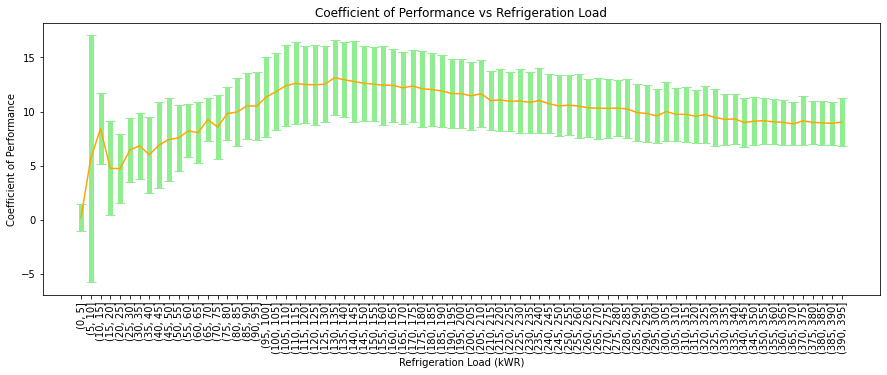

In [32]:
PlotCOPvsLoad(0, 400, 5)    

In [33]:
import ipywidgets

ipywidgets.interactive(PlotCOPvsLoad, lower=(0.0, working.kWR.min()), upper=(working.kWR.min(), working.kWR.max()), step=(1,100))

interactive(children=(FloatSlider(value=0.0, description='lower', max=7.512000167597105e-38), FloatSlider(valu…

In [34]:
working.corr()

,Flow,EnterTemp,LeaveTemp,kWE,kWR,COP,month
Flow,1.000000,0.548675,-0.147840,0.728911,0.827825,-0.205562,-0.065788
EnterTemp,0.548675,1.000000,0.222446,0.553913,0.679390,0.073520,0.007936
LeaveTemp,-0.147840,0.222446,1.000000,-0.449607,-0.463521,0.556739,-0.023226
kWE,0.728911,0.553913,-0.449607,1.000000,0.882772,-0.527529,-0.027581
kWR,0.827825,0.679390,-0.463521,0.882772,1.000000,-0.347025,-0.009968
COP,-0.205562,0.073520,0.556739,-0.527529,-0.347025,1.000000,-0.020599
month,-0.065788,0.007936,-0.023226,-0.027581,-0.009968,-0.020599,1.000000


# How often is Chiller 1 running?

In [35]:
def percentageOn(group) :
    return 100 * len(group[group.kWE > 0]) / len(group)

In [36]:
percentageOn(chiller1)

80.16126995737493

In [37]:
def PlotChillerRunningBy(columns, label, first, labels) :
    groups = chiller1.groupby(columns).apply(percentageOn)
    plot = groups.plot(figsize=(15,5))
    plot.set_xticks(range(first,len(labels)+first), labels)
    plot.set_title('Time running by ' + label)
    plot.set_ylabel('%')
    plot.set_xlabel(label)

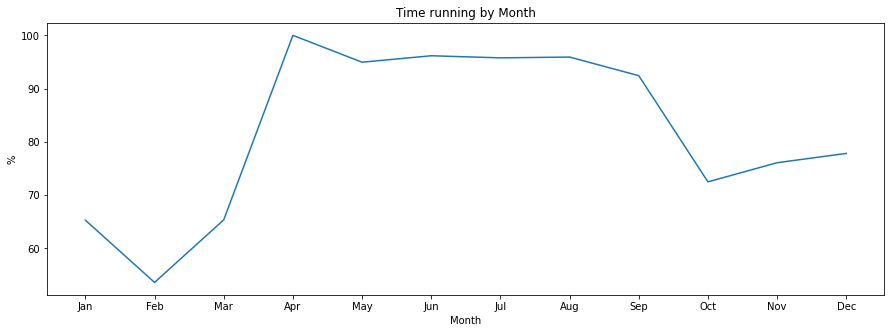

In [38]:
PlotChillerRunningBy(chiller1.index.month, 'Month', 1, month_labels)

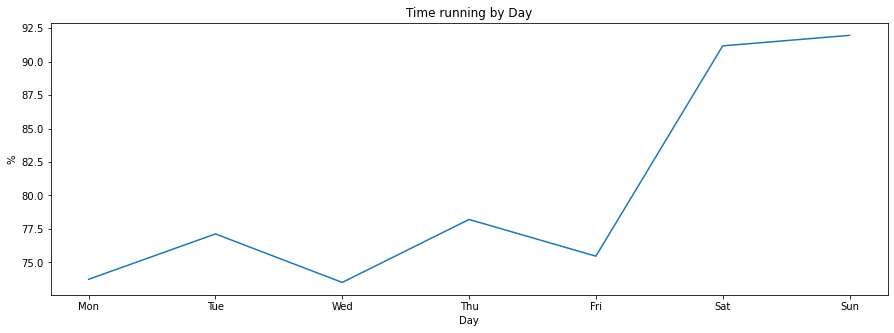

In [39]:
PlotChillerRunningBy(chiller1.index.dayofweek, 'Day', 0, day_labels)

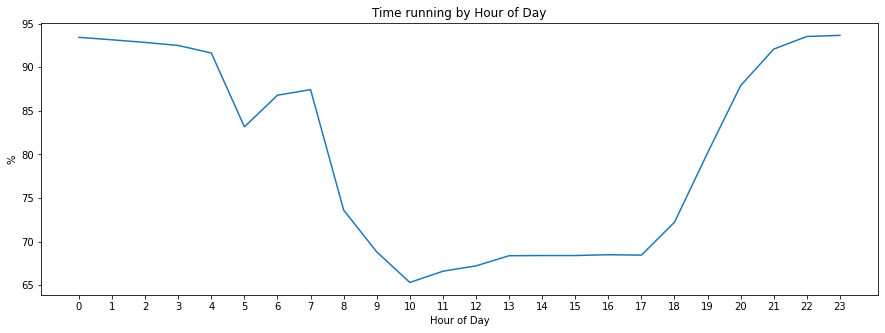

In [40]:
PlotChillerRunningBy(chiller1.index.hour, 'Hour of Day', 0, range(0,24))